# TITANIC SURVIVAL PREDICTION

Problem Statement:

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.

In this challenge, we ask you to complete the analysis of what sorts of people were likely to survive. In particular, we ask you to apply the tools of machine learning to predict which passengers survived the tragedy.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [44]:
train=pd.read_csv("titanic_train.csv")

In [45]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [46]:
#Checking for missing values

train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

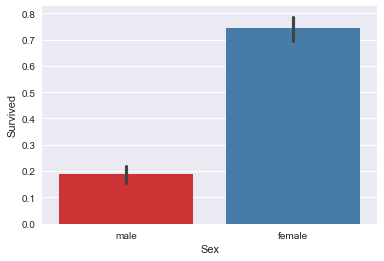

In [47]:
#No of females survived is higher compared to males

sns.barplot(x=train["Sex"],y=train["Survived"],palette="Set1")

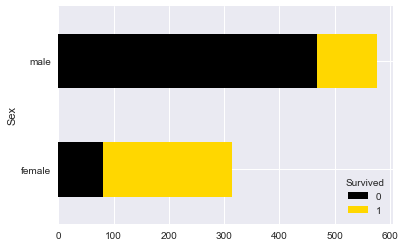

In [48]:
pd.crosstab([train.Sex],train.Survived).plot(kind="barh",stacked=True,color=["black","gold"])

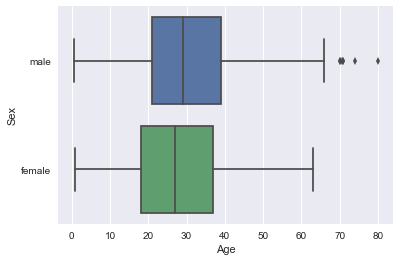

In [49]:
sns.boxplot(x=train["Age"],y=train["Sex"])

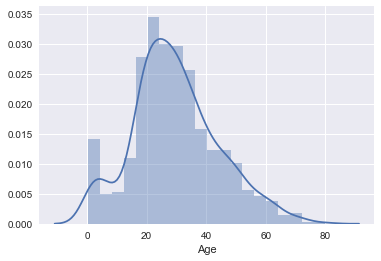

In [50]:
sns.set(color_codes=True)
sns.distplot(train["Age"].dropna())     #Age is normally distributed 

In [51]:
#Converting the ticket feature into new feature by removing 
#the numbers and replacing those instances which only have
#numbers by "Others"

def tic_transform(train):
    if len(train.split(" "))==2:
        a=train.split(" ")[0].replace("/","").replace(".","")
        a.replace(".","")
        return a
    else:
        return "Others"

m=train["Ticket"].apply(tic_transform)
train["Ticket1"]=np.zeros(len(m))

for i in range(0,len(m)):
    train["Ticket1"][i]=m[i]

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [52]:
train.Ticket1.unique()

array(['A5', 'PC', 'STONO2', 'Others', 'PP', 'CA', 'SCParis', 'SCA4', 'A4',
       'SP', 'SOC', 'WC', 'SOTONOQ', 'WEP', 'C', 'SCPARIS', 'SOP', 'Fa',
       'FCC', 'SWPP', 'SCOW', 'PPP', 'SC', 'SCAH', 'AS', 'SOPP', 'FC',
       'SOTONO2', 'CASOTON'], dtype=object)

In [53]:
def feature_transformation(train):    

    def f_t(train):
        if "Mr." in train.split(" "):                      #From the Name column we extract the titles of the passengers
            train="Mr"                                     #and form 5 different categories namely "Mr","Mrs","Master"
        elif "Mrs." in train.split(" "):                   #"Miss" and "Others" for the other titles
            train="Mrs"
        elif "Miss." in train.split(" "):
            train="Miss"
        elif "Master." in train.split(" "):
            train="Master"
        else:
            train="Others"
        return train
    
    train["Name"]=train["Name"].apply(f_t)

    j=train.groupby(["Name"])["Age"].median()           #Filling the missing age values by the median of each category in Name 
                                                        #created above
    for i in range(0,len(train)):
        if np.isnan(train["Age"][i]):
            if train["Name"][i]=="Mr":
                train["Age"][i]=int(j["Mr"])
            if train["Name"][i]=="Mrs":
                train["Age"][i]=int(j["Mrs"])   
            if train["Name"][i]=="Master":
                train["Age"][i]=int(j["Master"])
            if train["Name"][i]=="Others":
                train["Age"][i]=int(j["Others"])
            if train["Name"][i]=="Miss":
                train["Age"][i]=int(j["Miss"])     

    def c_t(train):                                     #Extracting the first letter of the cabin names
        train=(str(train)[0]).upper()
        return train
    
    train["Cabin"]=train["Cabin"].apply(c_t)
    
    train.drop(["Ticket","Name","PassengerId"],axis=1,inplace=True)   #Dropping the columns we don't require
    train["Embarked"]=train["Embarked"].fillna("S")
    
    train=pd.get_dummies(data=train,columns=["Sex","Embarked"])        #Creating dummy columns for efficiency purpose
    
    from sklearn.preprocessing import LabelEncoder
    le=LabelEncoder()                                                   #converting categorical variables into numerical form
    train["Cabin"]=le.fit_transform(train["Cabin"])
    train["Ticket1"]=le.fit_transform(train["Ticket1"])
    train.Fare=train.Fare.fillna(value=np.mean(train.Fare))
    
    return(train)

In [54]:
train=feature_transformation(train)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

In [55]:
train.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Cabin,Ticket1,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,3,22.0,1,0,7.2500,7,1,0,1,0,0,1
1,1,1,38.0,1,0,71.2833,2,10,1,0,1,0,0
2,1,3,26.0,0,0,7.9250,7,25,1,0,0,0,1
3,1,1,35.0,1,0,53.1000,2,9,1,0,0,0,1
4,0,3,35.0,0,0,8.0500,7,9,0,1,0,0,1
5,0,3,30.0,0,0,8.4583,7,9,0,1,0,1,0
6,0,1,54.0,0,0,51.8625,4,9,0,1,0,0,1
7,0,3,2.0,3,1,21.0750,7,9,0,1,0,0,1
8,1,3,27.0,0,2,11.1333,7,9,1,0,0,0,1
9,1,2,14.0,1,0,30.0708,7,9,1,0,1,0,0


Null accuracy

In [56]:
print(sum(train["Survived"]==0)/float(len(train))) #To get baseline accuracy for our model
print(sum(train["Survived"]==1)/float(len(train)))

0.616161616162
0.383838383838


In [57]:
train.reset_index(drop=True,inplace=True)

In [58]:
y=train.pop("Survived")
X=train

Logistic Regression

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV

In [65]:
[X_train,X_test,y_train,y_test]=train_test_split(X,y,random_state=10,test_size=.2)

In [66]:
log=LogisticRegression(max_iter=1000,random_state=0)

log.fit(X_train,y_train)

predict_log=log.predict(X_test)

accuracy_score(y_true=y_test,y_pred=predict_log)

0.83240223463687146

In [67]:
pipeline_log=Pipeline([("clf",LogisticRegression(random_state=0))])

parameter_log={"clf__max_iter":(100,200,400,500,800,1000),"clf__C":(.01,.03,.1,.3,1,3,10,100,1000),"clf__penalty":("l1","l2")}

gsearch_log=GridSearchCV(pipeline_log,parameter_log,scoring="accuracy",n_jobs=-1,cv=10)

gsearch_log.fit(X_train,y_train)

gsearch_log.best_params_

gsearch_log.best_score_

0.7963483146067416

In [69]:
prediction_log=gsearch_log.predict(X_test)
accuracy_score(y_test,prediction_log)

0.83240223463687146

Gradient Bossting Classifier with Parameter Tuning

In [70]:
from sklearn.ensemble import GradientBoostingClassifier

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [72]:
X_train

array([[ 1.        ,  0.35285248,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.5       ,  0.33400352,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        ,  0.43453129,  0.125     , ...,  0.        ,
         0.        ,  1.        ],
       ..., 
       [ 0.        ,  0.37170143,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.        ,  0.14551395,  0.125     , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.5       ,  0.44709726,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

gsearch1

In [73]:
pipeline1=Pipeline([("clf",GradientBoostingClassifier(learning_rate=0.1, min_samples_split=10,min_samples_leaf=2,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10))])

In [74]:
parameters1={"clf__n_estimators":(20,30,40,50,60,70,80)}

In [75]:
gsearch1=GridSearchCV(pipeline1,parameters1,scoring='accuracy',n_jobs=-1,cv=10)

In [76]:
gsearch1.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,...       presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__n_estimators': (20, 30, 40, 50, 60, 70, 80)},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [77]:
gsearch1.best_params_

{'clf__n_estimators': 70}

In [78]:
gsearch1.best_score_

0.8300561797752809

gsearch2

In [79]:
pipeline2=Pipeline([("clf",GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,max_features='sqrt',subsample=0.8,random_state=10))])

In [80]:
parameters2={'clf__max_depth':(2,3,4,5,6,7,8,9),"clf__min_samples_split":(5,10,15,20,30,40,50),"clf__min_samples_leaf":(2,4,6,8,10,12)}

In [81]:
gsearch2=GridSearchCV(pipeline2,parameters2,scoring='accuracy',n_jobs=-1,cv=10)

In [82]:
gsearch2.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features='sqrt', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,...       presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__max_depth': (2, 3, 4, 5, 6, 7, 8, 9), 'clf__min_samples_split': (5, 10, 15, 20, 30, 40, 50), 'clf__min_samples_leaf': (2, 4, 6, 8, 10, 12)},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [83]:
gsearch2.best_params_

{'clf__max_depth': 8, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 40}

In [84]:
gsearch2.best_score_

0.8398876404494382

gsearch3

In [85]:
pipeline3=Pipeline([("clf",GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,max_depth=8,min_samples_leaf=4,min_samples_split=40,subsample=.8,random_state=10))])

In [86]:
parameters3={"clf__max_features":(2,3,4,5,6,7)}

In [87]:
gsearch3=GridSearchCV(pipeline3,parameters3,n_jobs=-1,scoring="accuracy",cv=10)

In [88]:
gsearch3.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
 ...       presort='auto', random_state=10, subsample=0.8, verbose=0,
              warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__max_features': (2, 3, 4, 5, 6, 7)},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [89]:
gsearch3.best_params_

{'clf__max_features': 3}

In [90]:
gsearch3.best_score_

0.8398876404494382

gsearch4

In [91]:
pipeline4=Pipeline([("clf",GradientBoostingClassifier(learning_rate=0.1,n_estimators=70,max_depth=8,min_samples_leaf=4,min_samples_split=40,max_features=3,random_state=10))])

In [92]:
parameters4={"clf__subsample":(.6,.7,.75,.8,.85,.9,.95,1)}

In [93]:
gsearch4=GridSearchCV(pipeline4,parameters4,n_jobs=-1,scoring="accuracy",cv=10)

In [94]:
gsearch4.fit(X_train,y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('clf', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=3, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
    ...       presort='auto', random_state=10, subsample=1.0, verbose=0,
              warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'clf__subsample': (0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1)},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [95]:
gsearch4.best_params_

{'clf__subsample': 0.8}

In [96]:
gsearch4.best_score_

0.8398876404494382

In [97]:
gbm=GradientBoostingClassifier(n_estimators=140,learning_rate=0.05,max_depth=8,max_features=3,min_samples_leaf=4,min_samples_split=40,random_state=10,subsample=.8)
gbm.fit(X_train,y_train)
predictions=gbm.predict(X_test)
accuracy_score(y_test,predictions)

0.83798882681564246

In [98]:
gbm1=GradientBoostingClassifier(n_estimators=280,learning_rate=0.01,max_depth=8,max_features=3,min_samples_leaf=4,min_samples_split=40,random_state=10,subsample=.8)
gbm1.fit(X_train,y_train)
predictions=gbm1.predict(X_test)
accuracy_score(y_test,predictions)

0.84916201117318435

In [99]:
gbm2=GradientBoostingClassifier(n_estimators=560,learning_rate=0.005,max_depth=8,max_features=3,min_samples_leaf=4,min_samples_split=40,random_state=10,subsample=.8)
gbm2.fit(X_train,y_train)
predictions=gbm2.predict(X_test)
accuracy_score(y_test,predictions)

0.84916201117318435

In [100]:
gbm3=GradientBoostingClassifier(n_estimators=1120,learning_rate=0.005,max_depth=8,max_features=3,min_samples_leaf=4,min_samples_split=40,random_state=10,subsample=.8)
gbm3.fit(X_train,y_train)
predictions=gbm3.predict(X_test)
accuracy_score(y_test,predictions)

0.84916201117318435

In [101]:
def modelfit(alg, train, predict, performCV=True, printFeatureImportance=True, cv_folds=5):
    #Fit the algorithm on the data
    alg.fit(train, predict)
    from sklearn.cross_validation import StratifiedKFold
    from sklearn import metrics
    from sklearn.cross_validation import cross_val_score    
    #Predict training set:
    dtrain_predictions = alg.predict(train)
    dtrain_predprob = alg.predict_proba(train)[:,1]
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, train, predict, cv=cv_folds, scoring='accuracy')
    
    #Print model report:
    print("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(predict.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(predict, dtrain_predprob))
    
    if performCV:
        print ("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, X.columns).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Accuracy : 0.8866
AUC Score (Train): 0.947305
CV Score : Mean - 0.8283481 | Std - 0.04741252 | Min - 0.741573 | Max - 0.8988764


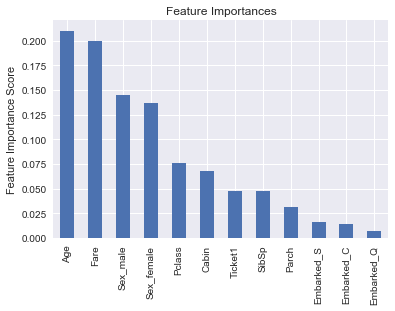

In [102]:
modelfit(gbm2,X,y,cv_folds=10)

XGBoost Classsifier with Parameter Tuning

In [103]:
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import cross_validation, metrics

In [104]:
xgb_1=XGBClassifier()

In [105]:
xgb_1.fit(X_train,y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [106]:
pred=xgb_1.predict(X_test)

In [107]:
accuracy_score(y_test,pred)

0.84916201117318435

In [110]:
def modelfit1(alg, dtrain, test,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain.values, label=test.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, test,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain)
    dtrain_predprob = alg.predict_proba(dtrain)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(test.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(test, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [111]:
xgb_2 = XGBClassifier(learning_rate =0.1,n_estimators=1000,max_depth=5,min_child_weight=1, gamma=0,subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4,scale_pos_weight=1, seed=27)
xgb_2.fit(X_train,y_train)
y_pred=xgb_2.predict(X_test)
accuracy_score(y_test,y_pred)

0.79329608938547491

In [112]:
param_test1 = {
"n_estimators":(10,20,40,60,90,100,120,150,200,250)
}
xgsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=5,min_child_weight=1,gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch2.fit(X_train,y_train)
xgsearch2.best_params_, xgsearch2.best_score_

({'n_estimators': 100}, 0.8300078247261347)

In [113]:
param_test2 = {
 'max_depth':(3,5,7,9,10),
 'min_child_weight':(1,3,5,6)
}
xgsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100,gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch2.fit(X_train,y_train)
xgsearch2.best_params_, xgsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.8314358372456964)

In [114]:
param_test2 = {
 'max_depth':(4,5,6),
 'min_child_weight':(3,4,5,6)
}
xgsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100,gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test2, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch2.fit(X_train,y_train)
xgsearch2.best_params_, xgsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.8314358372456964)

In [115]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
xgsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=100, max_depth=5,
 min_child_weight=5, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch3.fit(X_train,y_train)
xgsearch3.best_params_, xgsearch3.best_score_

({'gamma': 0.0}, 0.8314358372456964)

In [116]:
param_test4 = {
"n_estimators":(10,20,40,60,90,100,120,150,200,250)
}
xgsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=5,min_child_weight=5,gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test4, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch2.fit(X_train,y_train)
xgsearch2.best_params_, xgsearch2.best_score_

({'max_depth': 5, 'min_child_weight': 5}, 0.8314358372456964)

In [117]:
param_test5 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
xgsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=5,
 min_child_weight=5, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test5, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch5.fit(X_train,y_train)
xgsearch5.best_params_, xgsearch5.best_score_

({'colsample_bytree': 0.8, 'subsample': 0.8}, 0.8342331768388107)

In [118]:
param_test6 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
xgsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=5,
 min_child_weight=5, nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch6.fit(X_train,y_train)
xgsearch6.best_params_, xgsearch6.best_score_

({'colsample_bytree': 0.75, 'subsample': 0.8}, 0.8342331768388107)

In [119]:
param_test7 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
xgsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=5,
 min_child_weight=5, nthread=4, scale_pos_weight=1,seed=27,colsample_bytree=.75,subsample=.8), 
 param_grid = param_test7, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch7.fit(X_train,y_train)
xgsearch7.best_params_, xgsearch7.best_score_

({'reg_alpha': 1e-05}, 0.8342331768388107)

In [120]:
param_test8 = {
 'reg_alpha':[(1e-5)/2,1e-5,2e-5]
}
xgsearch8 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=120, max_depth=5,
 min_child_weight=5, nthread=4, scale_pos_weight=1,seed=27,colsample_bytree=.75,subsample=.8), 
 param_grid = param_test8, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch8.fit(X_train,y_train)
xgsearch8.best_params_, xgsearch8.best_score_

({'reg_alpha': 5e-06}, 0.8342331768388107)

In [121]:
param_test9 = {
"n_estimators":(110,120,150,200,250,500,1000)
}
xgsearch9 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, max_depth=5,min_child_weight=5,reg_alpha=1e-5,gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test9, scoring='accuracy',n_jobs=4,iid=False, cv=10)
xgsearch9.fit(X_train,y_train)
xgsearch9.best_params_, xgsearch9.best_score_

({'n_estimators': 120}, 0.8342331768388107)

In [122]:
xgb_3=XGBClassifier( learning_rate =0.1, max_depth=5,n_estimators=120,min_child_weight=5,nthread=4, scale_pos_weight=1,seed=27,colsample_bytree=.75,subsample=.8,reg_alpha=1e-5)
xgb_3.fit(X_train,y_train)
y_pred=xgb_3.predict(X_test)
accuracy_score(y_test,y_pred)

0.85474860335195535

In [123]:
xgb_4=XGBClassifier( learning_rate =0.05, max_depth=5,n_estimators=240,min_child_weight=5,nthread=4, scale_pos_weight=1,seed=27,colsample_bytree=.75,subsample=.8,reg_alpha=1e-5)
xgb_4.fit(X_train,y_train)
y_pred=xgb_4.predict(X_test)
accuracy_score(y_test,y_pred)

0.83240223463687146

In [124]:
xgb_5=XGBClassifier( learning_rate =0.001, max_depth=5,n_estimators=480,min_child_weight=5,nthread=4, scale_pos_weight=1,seed=27,colsample_bytree=.75,subsample=.8,reg_alpha=1e-5)
xgb_5.fit(X_train,y_train)
y_pred=xgb_5.predict(X_test)
accuracy_score(y_test,y_pred)

0.82122905027932958

In [125]:
xgb_6=XGBClassifier( learning_rate =0.0005, max_depth=5,n_estimators=960,min_child_weight=5,nthread=4, scale_pos_weight=1,seed=27,colsample_bytree=.75,subsample=.8,reg_alpha=1e-5)
xgb_6.fit(X_train,y_train)
y_pred=xgb_6.predict(X_test)
accuracy_score(y_test,y_pred)

0.82122905027932958


Model Report
Accuracy : 0.9046
AUC Score (Train): 0.962816


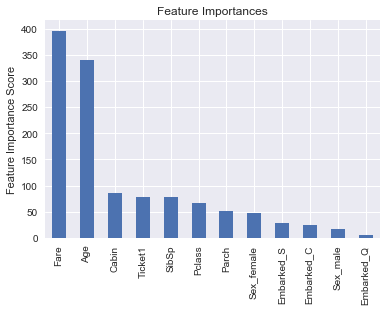

In [126]:
modelfit1(xgb_2, X, y)

Decision Tree Classifier

In [128]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
decision_tree_classifier=DecisionTreeClassifier(random_state=0)
cross_val_score(estimator=decision_tree_classifier,X=X_train,y=y_train,scoring="accuracy",cv=10).mean()

0.77658450704225357

Random Forest Classifier

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
random_forest_classifier=RandomForestClassifier(random_state=0)
cross_val_score(estimator=random_forest_classifier,X=X_train,y=y_train,scoring="accuracy",cv=10).mean()

0.78088810641627548

In [130]:
test=pd.read_csv("titanic_test.csv")
m=test["Ticket"].apply(tic_transform)
test["Ticket1"]=np.zeros(len(m))
for i in range(0,len(m)):
    test["Ticket1"][i]=m[i]
test=feature_transformation(test)

C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Program Files\Anaconda\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Program Files\Anaconda\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 


In [131]:
test.head()

,Pclass,Age,SibSp,Parch,Fare,Cabin,Ticket1,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,3,34.5,0,0,7.8292,7,9,0,1,0,1,0
1,3,47.0,1,0,7.0000,7,9,1,0,0,0,1
2,2,62.0,0,0,9.6875,7,9,0,1,0,1,0
3,3,27.0,0,0,8.6625,7,9,0,1,0,0,1
4,3,22.0,1,1,12.2875,7,9,1,0,0,0,1


In [132]:
test=scaler.transform(test)

In [133]:
predictions=gbm2.predict(test)        #Using Gradient Boosting Classifier as the final model for classification

In [134]:
submission=pd.DataFrame(columns=["PassengerID","Survived"])

submission["PassengerID"]=range(892,1310)
submission["Survived"]=predictions

In [135]:
submission.head()

,PassengerID,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [136]:
submission.to_csv("Submission1.csv", sep=",",index=None)